In [1]:
#!/usr/bin/env python

# In[1]:

import math
import numpy as np
# from GAIndividual import GAIndividual
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import index_collector_leadgen_facebook
sizepop, vardim, MAXGEN, params = 1000, 7, 15, [0.9, 0.1, 0.5]
DATE = datetime.datetime.today().date() -datetime.timedelta(1)

class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''

    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculate_fitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        best_index = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[best_index])
        self.avefitness = np.mean(self.fitness)
#         self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#         self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        self.trace[self.t, 0] = self.best.fitness
        self.trace[self.t, 1] = self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selection_operation()
            self.crossover_operation()
            self.mutation_operation()
            self.evaluate()
            best = np.max(self.fitness)
            best_index = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[best_index])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print("Optimal solution is:")
        print("m1--m2--m3--m4--m5--mspend--mbid")
        print(self.best.chrom)
        self.print_result()
        return self.best.chrom

    def selection_operation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        total_fitness = np.sum(self.fitness)
        accu_fitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accu_fitness[i] = sum1 + self.fitness[i] / total_fitness
            sum1 = accu_fitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accu_fitness[j]:
                    idx = 0
                    break
                elif r >= accu_fitness[j] and r < accu_fitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossover_operation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                cross_pos = random.randint(1, self.vardim - 1)
                for j in range(cross_pos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[j] * self.params[2] + \
                    (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] *  self.params[2] + \
                    (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutation_operation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutate_pos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutate_pos] = newpop[i].chrom[
                        mutate_pos] - (newpop[i].chrom[mutate_pos] - self.bound[0, mutate_pos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutate_pos] = newpop[i].chrom[
                        mutate_pos] + (self.bound[1, mutate_pos] - newpop[i].chrom[mutate_pos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def print_result(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()


class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''

    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]

    def calculate_fitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = ObjectiveFunc.fitness_function(self.chrom, df)

class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''

    def __init__(self, campaign_id=None):
        self.mydb = index_collector_leadgen_facebook.connectDB(
            "dev_facebook_test")

    def fitness_function(optimal_weight, df):
        df = df.drop(['charge_type'], axis=1)
        m1 = df['fb_pixel_lead'] / df['leadgen.other']
        m2 = df['leadgen.other'] / df['fb_pixel_view_content']
        m3 = df['fb_pixel_view_content'] / df['landing_page_view']
        m4 = df['landing_page_view'] / df['link_click']
        m5 = df['link_click'] / df['impressions']
        m_spend = (df['daily_budget'] - df['spend']) / df['daily_budget']
        m_bid = (df['campaign_bid'] - df['cost_per_fb_pixel_lead']) / df['campaign_bid']

        status = np.array([m1, m2, m3, m4, m5, m_spend, m_bid])
        status = np.nan_to_num(status)
        r = np.log( np.dot(optimal_weight, status) )
        return r

    def adset_fitness(optimal_weight, df):
        df = df.fillna(0)

        m1 = df['fb_pixel_lead'] / df['leadgen.other']
        m2 = df['leadgen.other'] / df['fb_pixel_view_content']
        m3 = df['fb_pixel_view_content'] / df['landing_page_view']
        m4 = df['landing_page_view'] / df['link_click']
        m5 = df['link_click'] / df['impressions']
        m_spend = (df['daily_budget'] - df['spend']) / df['daily_budget']
        m_bid = (df['bid_amount'] - df['cost_per_fb_pixel_lead']) / df['bid_amount']
        
        status = np.array([m1, m2, m3, m4, m5, m_spend, m_bid])
        status = np.nan_to_num(status)
        for idx, j in enumerate(status[:,0]):
            if np.isinf(j) or np.isneginf(j):
                status[idx,0] = -100
        r = np.log( np.dot(optimal_weight, status) )
        if math.isinf(r[0,0]):
            r[0,0] = -10
        return r

    def campaign_status(self, campaign_id):
        df_camp = pd.read_sql(
            "SELECT * FROM campaign_target WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        df_metrics = pd.read_sql(
            "SELECT * FROM campaign_leads_metrics WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        df_camp['campaign_bid'] = df_camp['ai_spend_cap']/df_camp['destination']
        self.charge_type = df_camp['charge_type'].iloc[0]
        spend = df_camp['spend'].iloc[0]
        campaign_cost_per_target = df_camp['cost_per_target'].iloc[0]
        campaign_target = df_camp['target'].iloc[0]
        impressions = df_camp['impressions'].iloc[0]
        df = pd.DataFrame(
            {
                'campaign_id': [campaign_id],
                'campaign_cost_per_target': [campaign_cost_per_target],
                'campaign_target': [campaign_target],
                'campaign_bid': [df_camp['campaign_bid'].iloc[0]],
                'daily_budget': [df_camp['daily_budget'].iloc[0]],
                'charge_type': [df_camp['charge_type'].iloc[0]]
            }
        )
        df = pd.merge(df, df_metrics, on=['campaign_id'])
        df.fillna(value=0, inplace=True)
        df = df.convert_objects(convert_numeric=True)
        return df

    def adset_status(self, adset_id):
        df = pd.DataFrame({'adset_id': [], 'target': [],
                           'impressions': [], 'bid_amount': []})

        df_adset = pd.read_sql(
            "SELECT * FROM adset_leads_metrics WHERE adset_id={} and DATE(request_time) = '{}' ORDER BY request_time DESC LIMIT 1".format(adset_id, DATE), con=self.mydb)
        df_adset.fillna(value=0, inplace=True)
        return df_adset


def ga_optimal_weight(campaign_id, df_weight):
    request_time = datetime.datetime.now().date()
    mydb = index_collector_leadgen_facebook.connectDB("dev_facebook_test")
#     df_weight = pd.read_sql("SELECT * FROM conversion_optimal_weight WHERE campaign_id={}".format(campaign_id), con=mydb)
    df_camp = pd.read_sql(
        "SELECT * FROM campaign_target WHERE campaign_id={}".format(campaign_id), con=mydb)
    charge_type = df_camp['charge_type'].iloc[0]
    adset_list = index_collector_leadgen_facebook.Campaigns(campaign_id, charge_type).get_adsets_active()
    for adset_id in adset_list:
        df = ObjectiveFunc().adset_status(adset_id)
        df['daily_budget'] = df_camp['daily_budget']
        df['leadgen.other'].iloc[0] = df['fb_pixel_lead'].iloc[0] if df['leadgen.other'].iloc[0] < df['fb_pixel_lead'].iloc[0] else df['leadgen.other'].iloc[0]
        df['fb_pixel_view_content'].iloc[0] = df['leadgen.other'].iloc[0] if df['fb_pixel_view_content'].iloc[0] < df['leadgen.other'].iloc[0] else df['fb_pixel_view_content'].iloc[0]
        df['landing_page_view'].iloc[0] = df['fb_pixel_view_content'].iloc[0] if df['landing_page_view'].iloc[0] < df['fb_pixel_view_content'].iloc[0] else df['landing_page_view'].iloc[0]
        r = ObjectiveFunc.adset_fitness(df_weight, df)
        print(r)
        df_final = pd.DataFrame({'campaign_id': campaign_id, 'adset_id': adset_id,
                                 'score': r[0], 'request_time': request_time}, index=[0])

        index_collector_leadgen_facebook.insertion("adset_score", df_final)



[on-going lead campaign_list]:  [23843368265910246 23843384204790368 23843445760160232 23843127784730010
 23843186222250380]
campaign_id: 23843368265910246
current time:  2019-06-06 10:45:38.303093


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:281: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/home/tim_su/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Generation 0: optimal function value is: 4.005815; average function value is 3.307257
Generation 1: optimal function value is: 4.005815; average function value is 3.394194
Generation 2: optimal function value is: 4.005815; average function value is 3.449199
Generation 3: optimal function value is: 4.005815; average function value is 3.468077
Generation 4: optimal function value is: 4.005815; average function value is 3.467820
Generation 5: optimal function value is: 4.005815; average function value is 3.469271
Generation 6: optimal function value is: 4.005815; average function value is 3.472116
Generation 7: optimal function value is: 4.005815; average function value is 3.481675
Generation 8: optimal function value is: 4.005815; average function value is 3.490159
Generation 9: optimal function value is: 4.005815; average function value is 3.492974
Generation 10: optimal function value is: 4.005815; average function value is 3.487293
Generation 11: optimal function value is: 4.005815; a

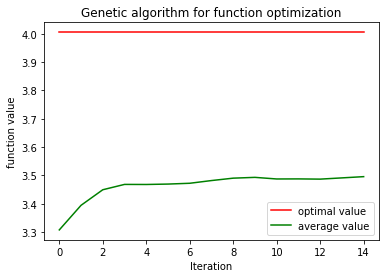

[campaign score]  [4.00581541]
[get_adsets_active] adset_active_list: ['23843368266200246', '23843368266210246', '23843368266220246', '23843411876570246']
[[4.7145501]]
[[4.79813068]]
[[4.8370229]]


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:253: RuntimeWarning: invalid value encountered in log


[[nan]]
optimal_weight: [5.31073749 9.86833836 5.14615534 9.88845213 3.16681367 9.85768319
 8.0010583 ]
0:01:07.707743
campaign_id: 23843384204790368
current time:  2019-06-06 10:45:38.303093
Generation 0: optimal function value is: 3.719658; average function value is 3.046601
Generation 1: optimal function value is: 3.719658; average function value is 3.092650
Generation 2: optimal function value is: 3.719658; average function value is 3.142850
Generation 3: optimal function value is: 3.719658; average function value is 3.139564
Generation 4: optimal function value is: 3.719658; average function value is 3.151159
Generation 5: optimal function value is: 3.719658; average function value is 3.158277
Generation 6: optimal function value is: 3.719658; average function value is 3.160743
Generation 7: optimal function value is: 3.719658; average function value is 3.169922
Generation 8: optimal function value is: 3.719658; average function value is 3.168550
Generation 9: optimal function val

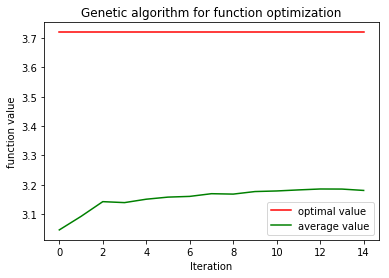

[campaign score]  [3.71965781]
[get_adsets_active] adset_active_list: ['23843512734210368', '23843521133660368', '23843521422360368', '23843524747510368']
[[3.51726017]]
[[-0.99716893]]
[[3.02512217]]
[[nan]]
optimal_weight: [5.90943445 9.56334521 8.28470571 0.86407843 9.88807725 9.44547594
 9.81439836]
0:02:15.870820
campaign_id: 23843445760160232
current time:  2019-06-06 10:45:38.303093


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:234: RuntimeWarning: invalid value encountered in log


Generation 0: optimal function value is: nan; average function value is nan
Generation 1: optimal function value is: nan; average function value is 2.141008
Generation 2: optimal function value is: nan; average function value is 2.139215
Generation 3: optimal function value is: nan; average function value is 2.143144
Generation 4: optimal function value is: nan; average function value is 2.143200
Generation 5: optimal function value is: nan; average function value is 2.155011
Generation 6: optimal function value is: nan; average function value is 2.158323
Generation 7: optimal function value is: nan; average function value is 2.164266
Generation 8: optimal function value is: nan; average function value is 2.176178
Generation 9: optimal function value is: nan; average function value is 2.183982
Generation 10: optimal function value is: nan; average function value is 2.187608
Generation 11: optimal function value is: nan; average function value is 2.201095
Generation 12: optimal function

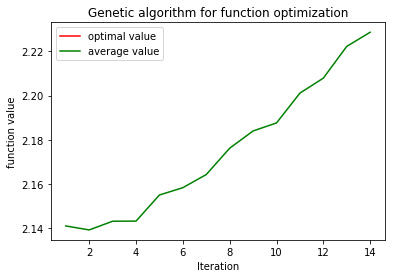

[campaign score]  [0.]
[get_adsets_active] adset_active_list: ['23843445760340232', '23843445760350232', '23843465138360232']
[[3.08716029]]
[[2.7190422]]
[[1.06086541]]
optimal_weight: [2.97712457 1.62264955 0.51475253 4.97081997 7.12221523 9.22766904
 0.53686726]
0:03:22.782581
campaign_id: 23843127784730010
current time:  2019-06-06 10:45:38.303093
Generation 0: optimal function value is: nan; average function value is nan
Generation 1: optimal function value is: nan; average function value is 2.453026
Generation 2: optimal function value is: nan; average function value is 2.453526
Generation 3: optimal function value is: nan; average function value is 2.453688
Generation 4: optimal function value is: nan; average function value is 2.456504
Generation 5: optimal function value is: nan; average function value is 2.453726
Generation 6: optimal function value is: nan; average function value is 2.458597
Generation 7: optimal function value is: nan; average function value is 2.450961
Gen

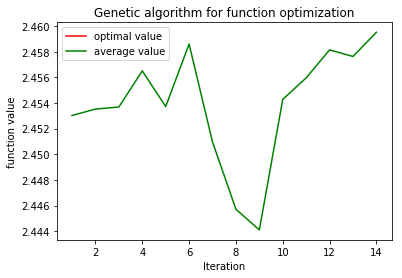

[campaign score]  [0.]
[get_adsets_active] adset_active_list: ['23843127792910010', '23843238623570010', '23843350915460010']
[[5.12036176]]
[[4.98821744]]
[[4.18648713]]
optimal_weight: [0.96968033 0.57297925 2.0557009  1.22285761 8.50697712 8.45210948
 0.42462871]
0:04:30.820006
campaign_id: 23843186222250380
current time:  2019-06-06 10:45:38.303093
Generation 0: optimal function value is: 3.862213; average function value is 3.211980
Generation 1: optimal function value is: 3.868819; average function value is 3.277850
Generation 2: optimal function value is: 3.868819; average function value is 3.318833
Generation 3: optimal function value is: 3.868819; average function value is 3.343732
Generation 4: optimal function value is: 3.868819; average function value is 3.370506
Generation 5: optimal function value is: 3.868819; average function value is 3.374645
Generation 6: optimal function value is: 3.868819; average function value is 3.383711
Generation 7: optimal function value is: 3.

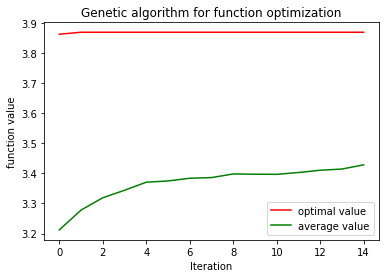

[campaign score]  [3.86881864]
[get_adsets_active] adset_active_list: ['23843186229630380', '23843293183160380']
[[5.13550708]]
[[4.86361333]]
optimal_weight: [4.69849075 9.23469031 9.62188336 0.34925099 3.18933749 9.75855974
 7.24266768]
0:05:37.057132
0:05:37.057362


In [2]:

if __name__ == "__main__":
    import datetime
    starttime = datetime.datetime.now()
    campaign_list = index_collector_leadgen_facebook.get_running_leadgen_campaign()['campaign_id'].unique()
    print('[on-going lead campaign_list]: ', campaign_list)
    for camp_id in campaign_list:
        print('campaign_id:', camp_id)
        print('current time: ', starttime )
        global df
        df = ObjectiveFunc().campaign_status(camp_id)
        df = df.fillna(0)
        df['leadgen.other'].iloc[0] = df['fb_pixel_lead'].iloc[0] if df['leadgen.other'].iloc[0] < df['fb_pixel_lead'].iloc[0] else df['leadgen.other'].iloc[0]
        df['fb_pixel_view_content'].iloc[0] = df['leadgen.other'].iloc[0] if df['fb_pixel_view_content'].iloc[0] < df['leadgen.other'].iloc[0] else df['fb_pixel_view_content'].iloc[0]
        df['landing_page_view'].iloc[0] = df['fb_pixel_view_content'].iloc[0] if df['landing_page_view'].iloc[0] < df['fb_pixel_view_content'].iloc[0] else df['landing_page_view'].iloc[0]
        
        bound = np.tile([[0], [10]], vardim)
        ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
        optimal = ga.solve()
        score = ObjectiveFunc.fitness_function(optimal, df)
        score = np.nan_to_num(score)
        if math.isinf(score):
            print('[score inf]')
            score = -100
        print('[campaign score] ', score)
        weight_columns = ['w1', 'w2', 'w3', 'w4',
                          'w5', 'w_spend', 'w_bid']
        df_weight = pd.DataFrame(
            data=[optimal], columns=weight_columns, index=[0])

        df_final = pd.DataFrame({'campaign_id': camp_id, 'score': score}, columns=[
                                'campaign_id', 'score'], index=[0])
        df_final = pd.concat([df_weight, df_final], axis=1,
                             sort=True, ignore_index=False)
        index_collector_leadgen_facebook.check_optimal_weight(camp_id, df_final)
        ga_optimal_weight(camp_id, df_weight)
        print('optimal_weight:', optimal)
        print(datetime.datetime.now()-starttime)
    print(datetime.datetime.now()-starttime)

In [4]:
#!jupyter nbconvert --to script genetic_algorithm_leadgen_facebook.ipynb

[NbConvertApp] Converting notebook genetic_algorithm_leadgen_facebook.ipynb to script
[NbConvertApp] Writing 14904 bytes to genetic_algorithm_leadgen_facebook.py
